## Use LSTM instead of GRU for Encoding

In [21]:
from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np
import os as os
import json

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers, callbacks, models
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
from datetime import datetime

from keras import regularizers

In [2]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))





In [16]:
RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 128
EPOCHS = 40
MODEL_NAME = "LSTM"
# Regularization parameter
LAMBDA = 0.03
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))

try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise




RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100


In [17]:
# Default QA1 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))
np.random.shuffle(train)
np.random.shuffle(test)
vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))


C:\ProgramData\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'is', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went']
x.shape = (1000, 552)
xq.shape = (1000, 5)
y.shape = (1000, 36)
story_maxlen, query_maxlen = 552, 5


In [18]:
print("Building the embedding matrix...")
GLOVE_PATH = '..\\Embeddings'


f = open(os.path.join(GLOVE_PATH,"glove.6B.{}d.txt".format(EMBED_HIDDEN_SIZE)), 'r', encoding = "ANSI")
embeddings_index = {}
for line in f:
    values = line.split(" ")
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        print(values[1:])
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_idx) + 1, EMBED_HIDDEN_SIZE))
for word, i in word_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Found %s word vectors.' % len(embeddings_index))

Building the embedding matrix...
Found 400000 word vectors.


In [19]:
print('Build model...')



question_Input = layers.Input(shape=xq[0].shape, name='question_Input')
story_Input = layers.Input(shape=x[0].shape, name='story_Input')

#Embed question
q_Embedding = layers.Embedding(input_dim = vocab_size, output_dim = EMBED_HIDDEN_SIZE, \
                               weights = [embedding_matrix], input_length = query_maxlen)(question_Input)
# Bidirectional GRU (optimal dropout approx 0.4 without regularization)
q_Encode = layers.Bidirectional(recurrent.LSTM(EMBED_HIDDEN_SIZE, return_sequences=True,\
                                              kernel_regularizer = regularizers.l2(LAMBDA), dropout=0.3))(q_Embedding)
q_Encode = layers.Reshape((query_maxlen, 2*EMBED_HIDDEN_SIZE))(q_Encode)

#Embed story
s_Embedding = layers.Embedding(input_dim = vocab_size, output_dim = EMBED_HIDDEN_SIZE, \
                               weights = [embedding_matrix], input_length = story_maxlen)(story_Input)
# Bidirectional GRU (optimal dropout approx 0.4 without regularization)
s_Encode = layers.Bidirectional(recurrent.LSTM(EMBED_HIDDEN_SIZE, return_sequences=True, \
                                              kernel_regularizer = regularizers.l2(LAMBDA), dropout=0.3))(s_Embedding)
s_Encode = layers.Reshape((story_maxlen, 2*EMBED_HIDDEN_SIZE))(s_Encode)

# Attention Layer
# Multiply between context and query to form attention
# Resultant matrix should be MxN, taking in Mxd and Nxd 
# embedded question/answer matrices where d is 2*EMBED_HIDDEN_SIZE
dot_merge = layers.Dot(axes = [2,2])([s_Encode, q_Encode])

# Flatten and compute softmax for each attent distro
flat = Flatten()(dot_merge)
dense = layers.Dense(query_maxlen * story_maxlen, kernel_regularizer = regularizers.l2(LAMBDA))(flat)
# act = layers.Activation("softmax")(dense)
act = layers.Activation("softmax")(dot_merge)


# Reshape back into the original dimensions (MxN)
act_resh = layers.Reshape((story_maxlen, query_maxlen), input_shape=(query_maxlen,))(act)
# Compute attention output as an element-wise multiplication
attn_out = layers.Dot(axes=[2,1])([act_resh, q_Encode])
# Next we concatenate to form a blended representation of the same dimension as an encoded question,
# of which there exists one for every given context hidden state. Should be 4H x 2N
blended = layers.Concatenate(axis=2)([s_Encode, attn_out])
flat2 = Flatten()(blended)
#relu = layers.Activation("relu")(flat2)

#####
# TODO: Finish Logit + fully connected layer for RELU 
relu = layers.Dense(EMBED_HIDDEN_SIZE, activation = "relu")(flat2)
#logit = layers.Dense(1)(relu)
#####
#print(relu.get_shape(), logit.get_shape())


dense2 = layers.Dense(vocab_size, activation = "softmax", kernel_regularizer = regularizers.l2(LAMBDA))(relu)
######
# TODO: Add vanilla softmax at output (no weight vector here, i.e. no Dense) 
# dense2 = layers.Activation("softmax")(logit)
#####

model = Model(inputs=[story_Input, question_Input], outputs = [dense2])
print(model.summary())

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Build model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
story_Input (InputLayer)        (None, 552)          0                                            
__________________________________________________________________________________________________
question_Input (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 552, 50)      1800        story_Input[0][0]                
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 5, 50)        1800        question_Input[0][0]             
______________________________________________________________________________________________

In [ ]:
print('Training')
print(model.summary())
now = datetime.now()
currDate = "{}-{}-{}".format(now.month, now.day, now.year)

outpath = "../Outputs"
modelFilename = "{}_{}.h5".format(MODEL_NAME, currDate)
histFilename = "{}_history_{}.json".format(MODEL_NAME, currDate)


saverCallback = callbacks.ModelCheckpoint(filepath = os.path.join(outpath, modelFilename), monitor = "val_loss", verbose = 1)
history = model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=100,
          validation_split=0.05,
          callbacks = [saverCallback])
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)

with open(os.path.join(outpath, histFilename), 'w') as histFile:
    json.dump(history.history, histFile)
    
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Training
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
story_Input (InputLayer)        (None, 552)          0                                            
__________________________________________________________________________________________________
question_Input (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 552, 50)      1800        story_Input[0][0]                
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 5, 50)        1800        question_Input[0][0]             
__________________________________________________________________________________________________
b

In [11]:
import os, re
import json
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'datetime', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
outpath = "../Outputs"
hist = json.load(open(os.path.join(outpath, "LSTM_history_11-17-2018.json"), "r"))

In [13]:
xlen = len(hist[list(hist.keys())[0]])
print(xlen)
x_pts = [i for i in range(xlen)]

100


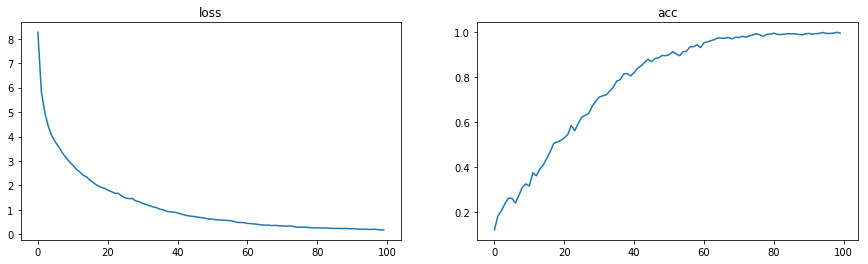

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey = False)
fig.set_figheight(4)
fig.set_figwidth(15)
sns.lineplot(x=x_pts, y=hist["loss"], ax = ax1).set_title("loss")
sns.lineplot(x=x_pts, y=hist["acc"], ax = ax2).set_title("acc")
fig.savefig(os.path.join(outpath, "{}_train_metrics.png".format(MODEL_NAME)))

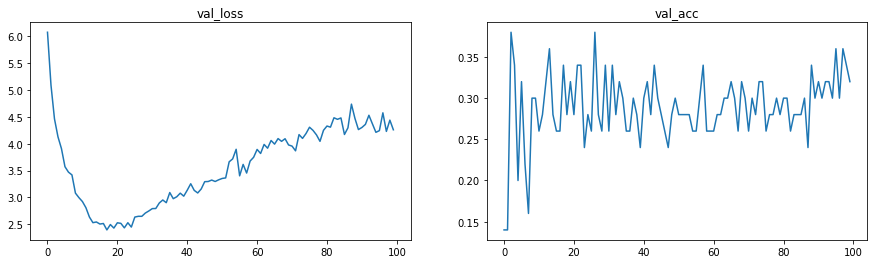

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey = False)
fig.set_figheight(4)
fig.set_figwidth(15)
sns.lineplot(x=x_pts, y=hist["val_loss"], ax = ax1).set_title("val_loss")
sns.lineplot(x=x_pts, y=hist["val_acc"], ax = ax2).set_title("val_acc")
fig.savefig(os.path.join(outpath, "{}_val_metrics.png".format(MODEL_NAME)))